# Soil Tutorial

## Introduction

This notebook is an introduction to the soil agent-based social network simulation framework.
In particular, we will focus on a specific use case: studying the propagation of news in a social network.

The steps we will follow are:

* Modelling the behavior of agents
* Running the simulation using different configurations
* Analysing the results of each simulation

But before that, let's import the soil module and networkx.

In [1]:
import soil
import networkx as nx
 
%load_ext autoreload
%autoreload 2

%pylab inline
# To display plots in the notebooed_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


## Basic concepts

There are three main elements in a soil simulation:
    
* The network topology. A simulation may use an existing NetworkX topology, or generate one on the fly
* Agents. There are two types: 1) network agents, which are linked to a node in the topology, and 2) environment agents, which are freely assigned to the environment.
* The environment. It assigns agents to nodes in the network, and stores the environment parameters (shared state for all agents).

Soil is based on ``simpy``, which is an event-based network simulation library.
Soil provides several abstractions over events to make developing agents easier.
This means you can use events (timeouts, delays) in soil, but for the most part we will assume your models will be step-based.


## Modeling behaviour

Our first step will be to model how every person in the social network reacts when it comes to news.
We will follow a very simple model (a finite state machine).

There are two types of people, those who have heard about a newsworthy event (infected) or those who have not (neutral).
A neutral person may heard about the news either on the TV (with probability **prob_tv_spread**) or through their friends.
Once a person has heard the news, they will spread it to their friends (with a probability **prob_neighbor_spread**).
Some users do not have a TV, so they only rely on their friends.

The spreading probabilities will change over time due to different factors.
We will represent this variance using an environment agent.

### Network Agents

A basic network agent in Soil would typically inherit from ``soil.agents.NetworkAgent``, and define its behaviour in every step of the simulation by implementing a ``run(self)`` method.
The most important attributes of the agent are:

* ``agent.state``, a dictionary with the state of the agent. This tate will be saved in every step of the simulation. It can be accessed from the agent as well:
```py
a = soil.agents.NetworkAgent(env=env)
agent.state['hours_of_sleep'] = 10
# is the same as
a['hours_of_sleep'] = 10
```
  The state of the agent is stored in every step of the simulation:
  ```py
  print(a['hours_of_sleep', 10]) # hours of sleep before step #10
  print(a[None, 0]) # whole state of the agent before step #0
  ```

* ``agent.env``, a reference to the environment. Most commonly used to get access to the environment parameters and the topology:
    ```py
    a.env.G.nodes() # Get all nodes ids in the topology
    a.env['minimum_hours_of_sleep']

    ```

Since our model is a finite state machine, we will be basing it on ``soil.agents.FSM``.

Agents that inherit from ``soil.agents.FSM`` do not need to specify a ``step`` method.
Instead, we describe each finite state with a function.
To change to another state, a function may return the new state, or the ``id`` of a state.
If no state is returned, the state remains unchanged.

The current state of the agent can be checked with ``agent.state['id']``. That state id can be used to look for other networks in that specific state


Our agent will have of two states, ``neutral`` (default) and ``infected``.

Here's the code:

In [2]:
import random

class NewsSpread(soil.agents.FSM):
    @soil.agents.default_state
    @soil.agents.state
    def neutral(self):
        r = random.random()
        if self['has_tv'] and r < self.model['prob_tv_spread']:
                return self.infected
        return
    
    @soil.agents.state
    def infected(self):
        prob_infect = self.model['prob_neighbor_spread']
        for neighbor in self.get_neighboring_agents(state_id=self.neutral.id):
            r = random.random()
            if r < prob_infect:
                neighbor.next_state(self.infected.id)
        return
        

### Environment agents

Environment agents allow us to control the state of the environment.
In this case, we will use an environment agent to simulate a very viral event.

When the event happens, the agent will modify the probability of spreading the rumor.

In [3]:
NEIGHBOR_FACTOR = 0.9
TV_FACTOR = 0.5


class NewsEnvironmentAgent(soil.agents.NetworkAgent):
    def step(self):
        if self.now == self['event_time']:
            self.model['prob_tv_spread'] = 1
            self.model['prob_neighbor_spread'] = 1
        elif self.now > self['event_time']:
            self.model['prob_tv_spread'] = self.model['prob_tv_spread'] * TV_FACTOR
            self.model['prob_neighbor_spread'] = self.model['prob_neighbor_spread'] * NEIGHBOR_FACTOR

### Testing the agents

Feel free to skip this section if this is your first time with soil.

Testing agents is not easy, and this is not a thorough testing process for agents.
Rather, this section is aimed to show you how to access internal pats of soil so you can test your agents.

First of all, let's check if our network agent has the states we would expect:

In [4]:
NewsSpread.states

{'neutral': <function __main__.NewsSpread.neutral(self)>,
 'infected': <function __main__.NewsSpread.infected(self)>}

Now, let's run a simulation on a simple network. It is comprised of three nodes:


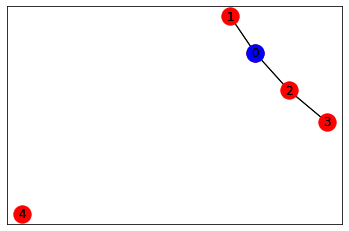

In [5]:
G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(2, 3)
G.add_node(4)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color='red')
nx.draw_networkx(G, pos, nodelist=[0], node_color='blue')

Let's run a simple simulation that assigns a NewsSpread agent to all the nodes in that network.
Notice how node 0 is the only one with a TV.

In [6]:
import importlib
importlib.reload(soil.agents)

<module 'soil.agents' from '/home/j/git/lab.gsi/soil/soil/soil/agents/__init__.py'>

In [7]:
env_params = {'prob_tv_spread': 0,
             'prob_neighbor_spread': 0}

MAX_TIME = 100
EVENT_TIME = 10

sim = soil.Simulation(topology=G,
                      num_trials=1,
                      max_time=MAX_TIME,
                      environment_agents=[{'agent_class': NewsEnvironmentAgent,
                                           'state': {
                                           'event_time': EVENT_TIME
                                         }}],
                      network_agents=[{'agent_class': NewsSpread,
                                      'weight': 1}],
                      states={0: {'has_tv': True}},
                      default_state={'has_tv': False},
                      environment_params=env_params)
env = sim.run_simulation(dry_run=True)[0]

INFO:soil:Using exporters: [<class 'soil.exporters.default'>]
INFO:soil:Output directory: None
INFO:soil:Starting simulation Unnamed at 21:51:19.
INFO:soil:NOT dumping results
INFO:soil:Starting Simulation Unnamed trial Unnamed_trial_1605822679-0170248 at 21:51:19.
INFO:soil:Finished Simulation Unnamed trial Unnamed_trial_1605822679-0170248 at 21:51:19 in 0.006684064865112305 seconds
INFO:soil:Finished simulation Unnamed at 21:51:19 in 0.011702775955200195 seconds


Now we can access the results of the simulation and compare them to our expected results

In [8]:
agents = list(env.network_agents)

# Until the event, all agents are neutral
for t in range(10):
    for a in agents:
        assert a['id', t] == a.neutral.id

# After the event, the node with a TV is infected, the rest are not
assert agents[0]['id', 11] == NewsSpread.infected.id
assert agents[2]['id', 11] == NewsSpread.neutral.id


# At the end, the agents connected to the infected one will probably be infected, too.
assert agents[1]['id', MAX_TIME] == NewsSpread.infected.id
assert agents[2]['id', MAX_TIME] == NewsSpread.infected.id

# But the node with no friends should not be affected
assert agents[4]['id', MAX_TIME] == NewsSpread.neutral.id
        

Lastly, let's see if the probabilities have decreased as expected:

In [9]:
assert abs(env.environment_params['prob_neighbor_spread'] - (NEIGHBOR_FACTOR**(MAX_TIME-1-10))) < 10e-4
assert abs(env.environment_params['prob_tv_spread'] - (TV_FACTOR**(MAX_TIME-1-10))) < 10e-6

## Running the simulation

To run a simulation, we need a configuration.
Soil can load configurations from python dictionaries as well as JSON and YAML files.
For this demo, we will use a python dictionary:

In [10]:
config = {
    'name': 'ExampleSimulation',
    'max_time': 20,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'generator': 'complete_graph',
        'n': 500,
    },
    'network_agents': [
        {
            'agent_class': NewsSpread,
            'weight': 1,
            'state': {
                'has_tv': False
            }
        },
        {
            'agent_class': NewsSpread,
            'weight': 2,
            'state': {
                'has_tv': True
            }
        }
    ],
    'environment_agents':[
        {'agent_class': NewsEnvironmentAgent,
         'state': {
             'event_time': 10
         }
        }
    ],
    'states': [ {'has_tv': True} ],
    'environment_params':{
        'prob_tv_spread': 0.01,
        'prob_neighbor_spread': 0.5
    }
}

Let's run our simulation:

In [11]:
soil.simulation.run_from_config(config, dry_run=True)

INFO:soil:Using config(s): ExampleSimulation
INFO:soil:Using exporters: [<class 'soil.exporters.default'>]
INFO:soil:Output directory: None
INFO:soil:Starting simulation ExampleSimulation at 21:51:20.
INFO:soil:NOT dumping results
INFO:soil:Starting Simulation ExampleSimulation trial ExampleSimulation_trial_1605822680-0185008 at 21:51:20.
INFO:soil:Finished Simulation ExampleSimulation trial ExampleSimulation_trial_1605822680-0185008 at 21:51:22 in 1.9917693138122559 seconds
INFO:soil:Finished simulation ExampleSimulation at 21:51:22 in 2.4902079105377197 seconds


In real life, you probably want to run several simulations, varying some of the parameters so that you can compare and answer your research questions.

For instance:
    
* Does the outcome depend on the structure of our network? We will use different generation algorithms to compare them (Barabasi-Albert and Erdos-Renyi)
* How does neighbor spreading probability affect my simulation? We will try probability values in the range of [0, 0.4], in intervals of 0.1.

In [12]:
network_1 = {
       'generator': 'erdos_renyi_graph',
        'n': 500,
        'p': 0.1
}
network_2 = {
       'generator': 'barabasi_albert_graph',
        'n': 500,
        'm': 2
}


for net in [network_1, network_2]:
    for i in range(5):
        prob = i / 10
        config['environment_params']['prob_neighbor_spread'] = prob
        config['network_params'] = net
        config['name'] = 'Spread_{}_prob_{}'.format(net['generator'], prob)
        s = soil.simulation.run_from_config(config, exporters=['default', 'csv'])

INFO:soil:Using config(s): Spread_erdos_renyi_graph_prob_0.0
INFO:soil:Using exporters: ['default', 'csv']
INFO:soil:Output directory: None
INFO:soil:Starting simulation Spread_erdos_renyi_graph_prob_0.0 at 21:51:22.
INFO:soil:Dumping results to /home/j/git/lab.gsi/soil/soil/examples/tutorial/soil_output/Spread_erdos_renyi_graph_prob_0.0
INFO:soil:Starting Simulation Spread_erdos_renyi_graph_prob_0.0 trial Spread_erdos_renyi_graph_prob_0-0_trial_1605822684-0959892 at 21:51:24.
INFO:soil:Finished Simulation Spread_erdos_renyi_graph_prob_0.0 trial Spread_erdos_renyi_graph_prob_0-0_trial_1605822684-0959892 at 21:51:24 in 0.2903263568878174 seconds
INFO:soil:Starting Dumping simulation Spread_erdos_renyi_graph_prob_0.0 trial Spread_erdos_renyi_graph_prob_0-0_trial_1605822684-0959892 at 21:51:24.
INFO:soil:Finished Dumping simulation Spread_erdos_renyi_graph_prob_0.0 trial Spread_erdos_renyi_graph_prob_0-0_trial_1605822684-0959892 at 21:51:24 in 0.0013904571533203125 seconds
INFO:soil:Start

INFO:soil:Using exporters: ['default', 'csv']
INFO:soil:Output directory: None
INFO:soil:Starting simulation Spread_barabasi_albert_graph_prob_0.0 at 21:51:32.
INFO:soil:Dumping results to /home/j/git/lab.gsi/soil/soil/examples/tutorial/soil_output/Spread_barabasi_albert_graph_prob_0.0
INFO:soil:Starting Simulation Spread_barabasi_albert_graph_prob_0.0 trial Spread_barabasi_albert_graph_prob_0-0_trial_1605822693-02196 at 21:51:33.
INFO:soil:Finished Simulation Spread_barabasi_albert_graph_prob_0.0 trial Spread_barabasi_albert_graph_prob_0-0_trial_1605822693-02196 at 21:51:33 in 0.08920121192932129 seconds
INFO:soil:Starting Dumping simulation Spread_barabasi_albert_graph_prob_0.0 trial Spread_barabasi_albert_graph_prob_0-0_trial_1605822693-02196 at 21:51:33.
INFO:soil:Finished Dumping simulation Spread_barabasi_albert_graph_prob_0.0 trial Spread_barabasi_albert_graph_prob_0-0_trial_1605822693-02196 at 21:51:33 in 0.002248525619506836 seconds
INFO:soil:Starting [CSV] Dumping simulation 

INFO:soil:Finished simulation Spread_barabasi_albert_graph_prob_0.4 at 21:51:34 in 0.2759675979614258 seconds


The results are conveniently stored in sqlite (history of agent and environment state) and the configuration is saved in a YAML file.

You can also export the results to GEXF format (dynamic network) and CSV using .`run_from_config(config, dump=['gexf', 'csv'])` or the command line flags `--graph --csv`.

In [13]:
!tree soil_output
!du -xh soil_output/*

soil_output
├── Spread_barabasi_albert_graph_prob_0.0
│   ├── backup
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-10-20_02.13.09
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-11-19_17.07.59
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-11-19_22.21.31
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-11-19_22.27.50
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-11-19_22.30.03
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2020-11-19_22.37.58
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.csv@2020-10-20_02.13.09
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.sqlite@2020-10-20_02.13.09
│   │   └── Spread_barabasi_albert_graph_prob_0.0_trial_0.stats.csv@2020-10-20_02.13.09
│   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.csv
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.db.sqlite
│   ├── Spr

364K	soil_output/Spread_barabasi_albert_graph_prob_0.0/backup
1.2M	soil_output/Spread_barabasi_albert_graph_prob_0.0
368K	soil_output/Spread_barabasi_albert_graph_prob_0.1/backup
1.2M	soil_output/Spread_barabasi_albert_graph_prob_0.1
364K	soil_output/Spread_barabasi_albert_graph_prob_0.2/backup
1.2M	soil_output/Spread_barabasi_albert_graph_prob_0.2
368K	soil_output/Spread_barabasi_albert_graph_prob_0.3/backup
1.2M	soil_output/Spread_barabasi_albert_graph_prob_0.3
364K	soil_output/Spread_barabasi_albert_graph_prob_0.4/backup
1.2M	soil_output/Spread_barabasi_albert_graph_prob_0.4
2.5M	soil_output/Spread_erdos_renyi_graph_prob_0.0/backup
3.6M	soil_output/Spread_erdos_renyi_graph_prob_0.0
2.5M	soil_output/Spread_erdos_renyi_graph_prob_0.1/backup
3.6M	soil_output/Spread_erdos_renyi_graph_prob_0.1
2.5M	soil_output/Spread_erdos_renyi_graph_prob_0.2/backup
3.6M	soil_output/Spread_erdos_renyi_graph_prob_0.2
2.5M	soil_output/Spread_erdos_renyi_graph_prob_0.3/backup
3.6M	soil_output/Spread_erdos_

## Analysing the results

### Loading data

Once the simulations are over, we can use soil to analyse the results.

Soil allows you to load results for specific trials, or for a set of trials if you specify a pattern. The specific methods are:

* `analysis.read_data(<directory pattern>)` to load all the results from a directory. e.g. `read_data('my_simulation/')`. For each trial it finds in each folder matching the pattern, it will return the dumped configuration for the simulation, the results of the trial, and the configuration itself. By default, it will try to load data from the sqlite database. 
* `analysis.read_csv(<csv_file>)` to load all the results from a CSV file. e.g. `read_csv('my_simulation/my_simulation_trial0.environment.csv')`
* `analysis.read_sql(<sqlite_file>)` to load all the results from a sqlite database . e.g. `read_sql('my_simulation/my_simulation_trial0.db.sqlite')`

Let's see it in action by loading the stored results into a pandas dataframe:

In [54]:
from soil import analysis
import pandas as pd

In [3]:
df = analysis.read_csv('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.csv')
df

key                                                SEED  \
agent_id                                            env   
t_step                                                    
0         Spread_barabasi_albert_graph_prob_0.0_trial_0   
1         Spread_barabasi_albert_graph_prob_0.0_trial_0   
2         Spread_barabasi_albert_graph_prob_0.0_trial_0   
3         Spread_barabasi_albert_graph_prob_0.0_trial_0   
4         Spread_barabasi_albert_graph_prob_0.0_trial_0   
5         Spread_barabasi_albert_graph_prob_0.0_trial_0   
6         Spread_barabasi_albert_graph_prob_0.0_trial_0   
7         Spread_barabasi_albert_graph_prob_0.0_trial_0   
8         Spread_barabasi_albert_graph_prob_0.0_trial_0   
9         Spread_barabasi_albert_graph_prob_0.0_trial_0   
10        Spread_barabasi_albert_graph_prob_0.0_trial_0   
11        Spread_barabasi_albert_graph_prob_0.0_trial_0   
12        Spread_barabasi_albert_graph_prob_0.0_trial_0   
13        Spread_barabasi_albert_graph_prob_0.0_trial_0   
14        Spread_barabasi_albert_graph_prob_0.0_trial_0   
15        Spread_barabasi_albert_graph_prob_0.0_trial_0   
16        Spread_barabasi_albert_graph_prob_0.0_trial_0   
17        Spread_barabasi_albert_graph_prob_0.0_trial_0   
18        Spread_barabasi_albert_graph_prob_0.0_trial_0   
19        Spread_barabasi_albert_graph_prob_0.0_trial_0   
20        Spread_barabasi_albert_graph_prob_0.0_trial_0   

key      agents.model_count.NewsSpread agents.state_count.infected  \
agent_id                         stats                       stats   
t_step                                                               
0                                  NaN                         NaN   
1                                  NaN                         NaN   
2                                  NaN                         NaN   
3                                  NaN                         NaN   
4                                  NaN                         NaN   
5                                  NaN                         NaN   
6                                  NaN                         NaN   
7                                  NaN                         NaN   
8                                  NaN                         NaN   
9                                  NaN                         NaN   
10                                 NaN                         NaN   
11                                 NaN                         NaN   
12                                 NaN                         NaN   
13                                 NaN                         NaN   
14                                 NaN                         NaN   
15                                 NaN                         NaN   
16                                 NaN                         NaN   
17                                 NaN                         NaN   
18                                 NaN                         NaN   
19                                 NaN                         NaN   
20                                 500                         480   

key      agents.state_count.neutral           event_time has_tv              \
agent_id                      stats NewsEnvironmentAgent      0     1    10   
t_step                                                                        
0                               NaN                   10   True  True  True   
1                               NaN                   10   True  True  True   
2                               NaN                   10   True  True  True   
3                               NaN                   10   True  True  True   
4                               NaN                   10   True  True  True   
5                               NaN                   10   True  True  True   
6                               NaN                   10   True  True  True   
7                               NaN                   10   True  True  True   
8                               N

Soil can also process the data for us and split the results into environment attributes and agent attributes:

In [4]:
env, agents = analysis.split_processed(df)

In [5]:
agents

key                event_time has_tv                                      \
agent_id NewsEnvironmentAgent      0     1    10   100   101   102   103   
t_step                                                                     
0                          10   True  True  True  True  True  True  True   
1                          10   True  True  True  True  True  True  True   
2                          10   True  True  True  True  True  True  True   
3                          10   True  True  True  True  True  True  True   
4                          10   True  True  True  True  True  True  True   
5                          10   True  True  True  True  True  True  True   
6                          10   True  True  True  True  True  True  True   
7                          10   True  True  True  True  True  True  True   
8                          10   True  True  True  True  True  True  True   
9                          10   True  True  True  True  True  True  True   
10                         10   True  True  True  True  True  True  True   
11                         10   True  True  True  True  True  True  True   
12                         10   True  True  True  True  True  True  True   
13                         10   True  True  True  True  True  True  True   
14                         10   True  True  True  True  True  True  True   
15                         10   True  True  True  True  True  True  True   
16                         10   True  True  True  True  True  True  True   
17                         10   True  True  True  True  True  True  True   
18                         10   True  True  True  True  True  True  True   
19                         10   True  True  True  True  True  True  True   
20                         10   True  True  True  True  True  True  True   

key                   ...        id                                         \
agent_id   104   105  ...        90        91       92        93        94   
t_step                ...                                                    
0         True  True  ...   neutral   neutral  neutral   neutral   neutral   
1         True  True  ...   neutral   neutral  neutral   neutral   neutral   
2         True  True  ...   neutral  infected  neutral   neutral   neutral   
3         True  True  ...   neutral  infected  neutral   neutral   neutral   
4         True  True  ...   neutral  infected  neutral   neutral   neutral   
5         True  True  ...   neutral  infected  neutral   neutral   neutral   
6         True  True  ...   neutral  infected  neutral   neutral   neutral   
7         True  True  ...   neutral  infected  neutral   neutral   neutral   
8         True  True  ...   neutral  infected  neutral   neutral   neutral   
9         True  True  ...   neutral  infected  neutral   neutral   neutral   
10        True  True  ...  infected  infected  neutral  infected   neutral   
11        True  True  ...  infected  infected  neutral  infected   neutral   
12        True  True  ...  infected  infected  neutral  infected   neutral   
13        True  True  ...  infected  infected  neutral  infected   neutral   
14        True  True  ...  infected  infected  neutral  infected   neutral   
15        True  True  ...  infected  infected  neutral  infected   neutral   
16        True  True  ...  infected  infected  neutral  infected   neutral   
17        True  True  ...  infected  infected  neutral  infected   neutral   
18        True  True  ...  infected  infected  neutral  infected  infected   
19        True  True  ...  infected  infected  neutral  infected  infected   
20        True  True  ...  infected  infected  neutral  infected  infected   

key                                                         
agent_id        95        96        97        98        99  
t_step                                                      
0          neutral   neutral   neutral   neutral   neutral  
1          neutral   neutral   neutral   neutral   neutral

The index of the results are the simulation step. Hence, we can access the state of the simulation at a given step (e.g., 13): 

In [6]:
agents.loc[13, 'id']

agent_id
0      infected
1      infected
10     infected
100    infected
101    infected
         ...   
95      neutral
96     infected
97     infected
98     infected
99     infected
Name: 13, Length: 500, dtype: object

Or, we can perform more complex tasks such as showing the agents that have changed their state between two simulation steps (2 and 1):

In [7]:
(agents.loc[2]['id'] != agents.loc[1]['id']).sum()

5

To focus on specific agents, we can swap the levels of the index:

In [8]:
agents.swaplevel(axis=1)

agent_id,NewsEnvironmentAgent,0,1,10,100,101,102,103,104,105,...,90,91,92,93,94,95,96,97,98,99
key,event_time,has_tv,has_tv,has_tv,has_tv,has_tv,has_tv,has_tv,has_tv,has_tv,...,id,id,id,id,id,id,id,id,id,id
t_step,,,,,,,,,,,,,,,,,,,,,
0,10,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
1,10,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
3,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
4,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
5,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
6,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
7,10,True,True,True,True,True,True,True,True,True,...,neutral,infected,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral


### Plotting data

If you don't want to work with pandas, you can also use some pre-defined functions from soil to conveniently plot the results:

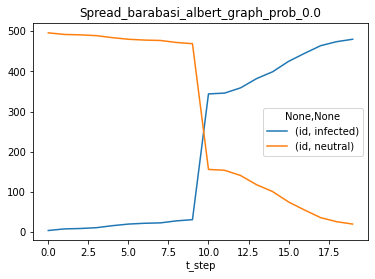

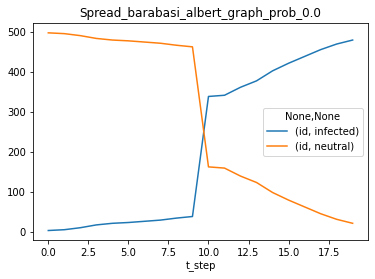

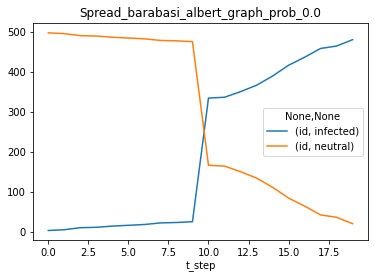

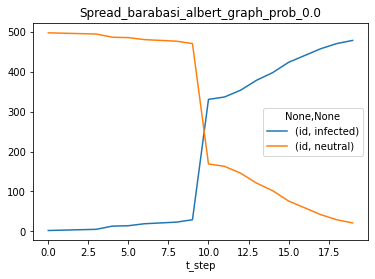

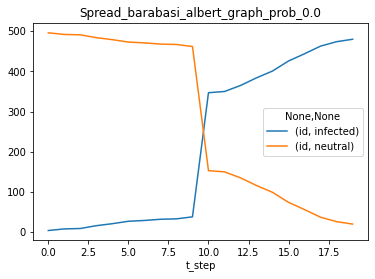

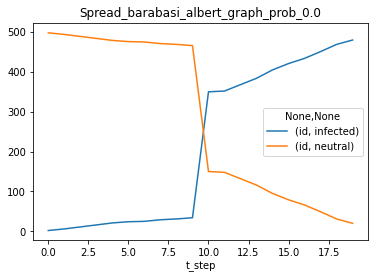

In [72]:
analysis.plot_all('soil_output/Spread_barabasi_albert_graph_prob_0.0/', analysis.get_count, 'id');

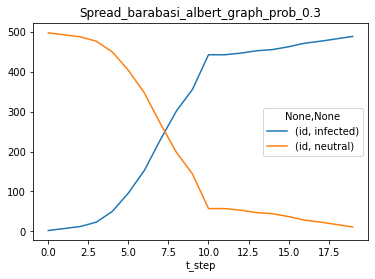

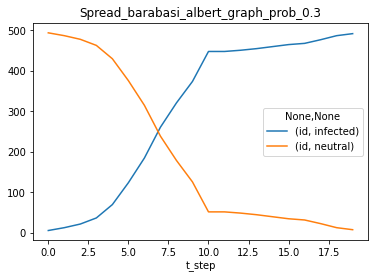

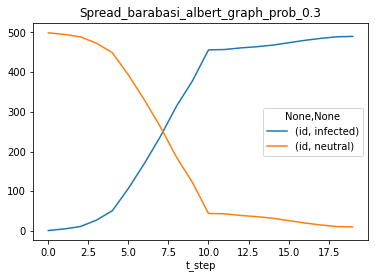

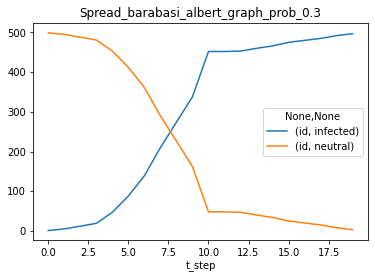

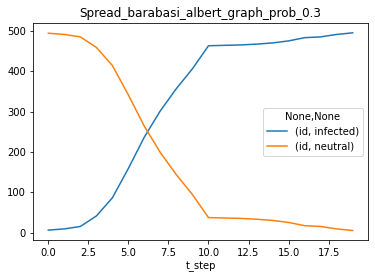

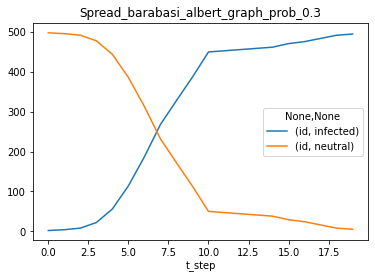

In [71]:
analysis.plot_all('soil_output/Spread_barabasi_albert_graph_prob_0.3/', analysis.get_count, 'id');

/home/j/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


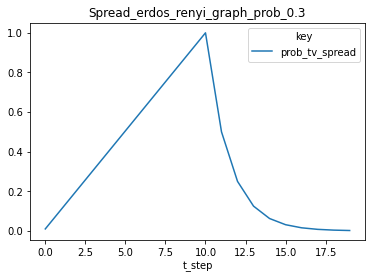

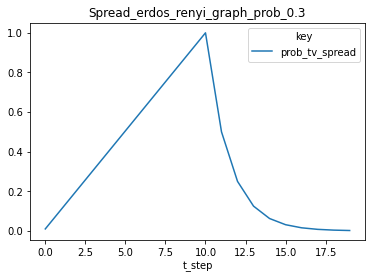

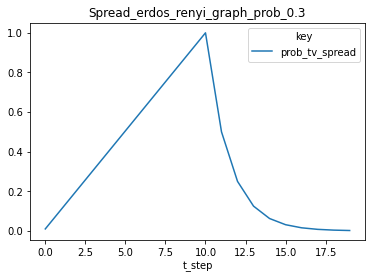

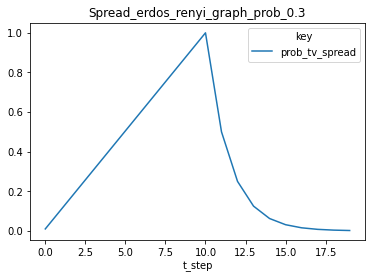

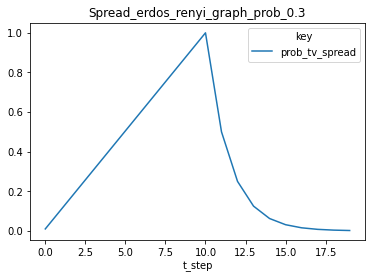

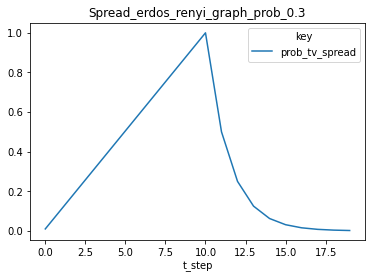

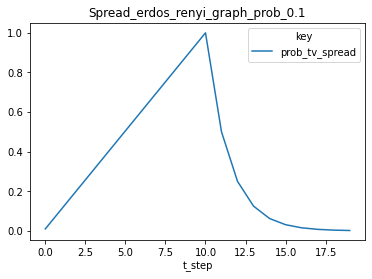

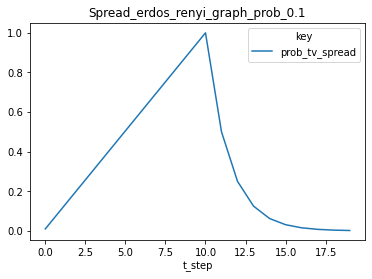

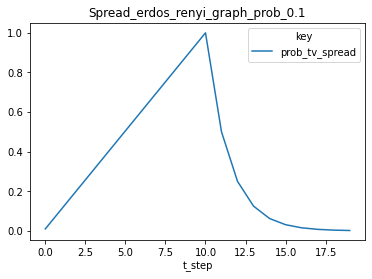

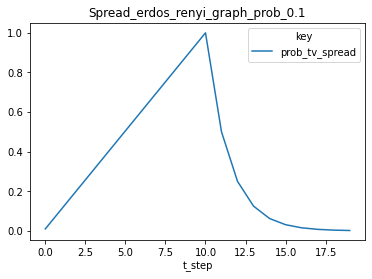

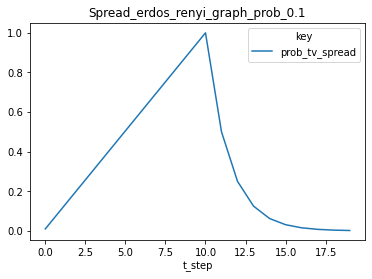

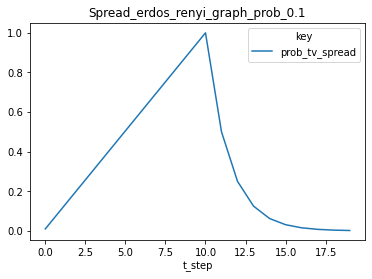

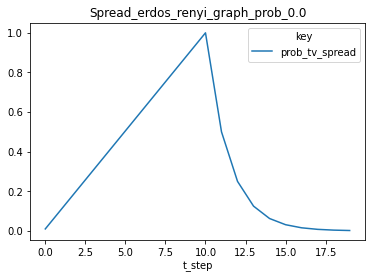

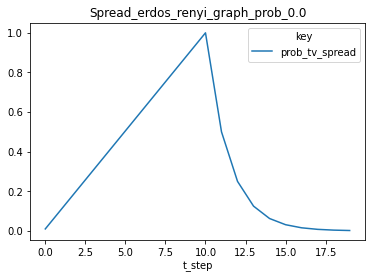

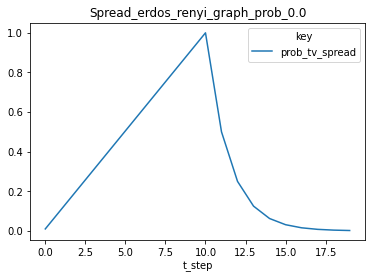

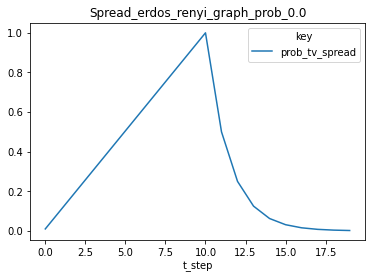

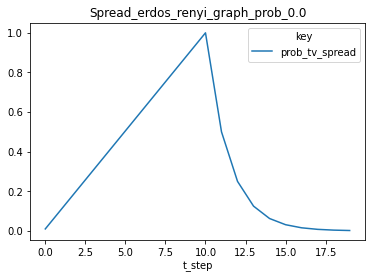

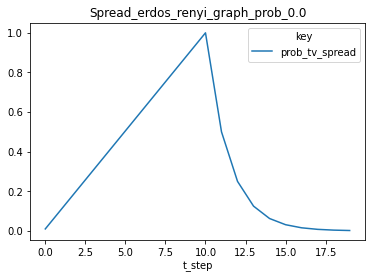

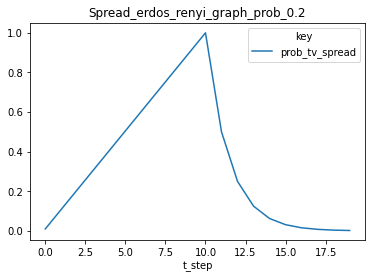

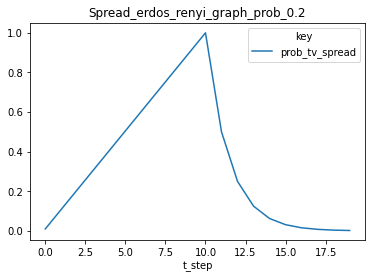

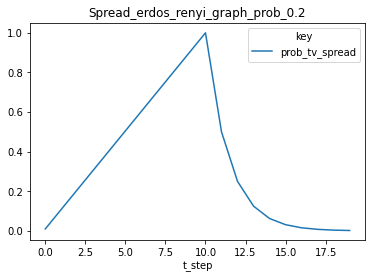

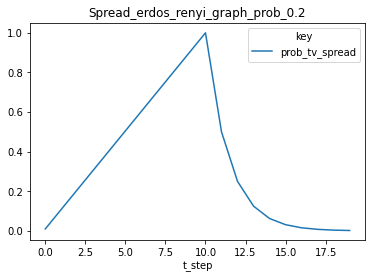

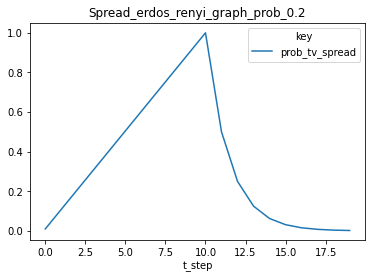

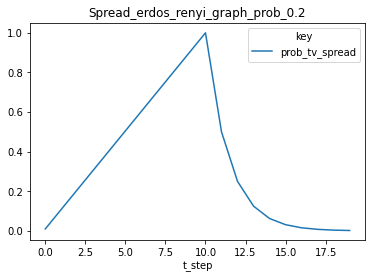

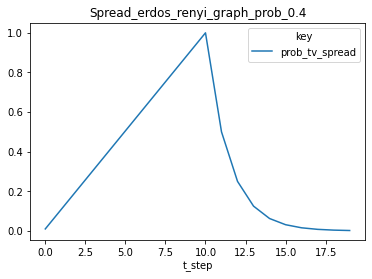

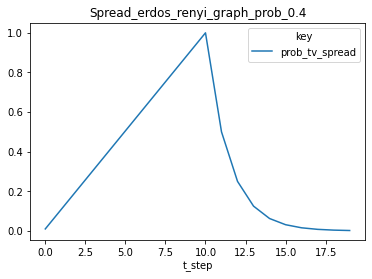

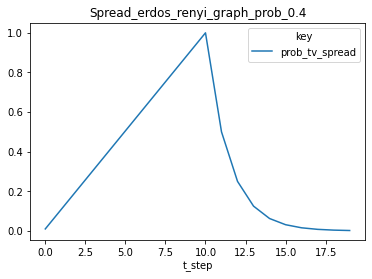

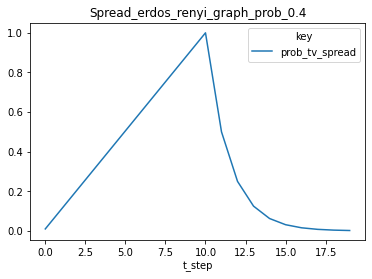

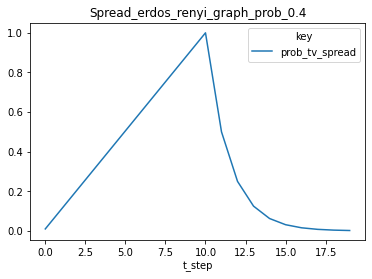

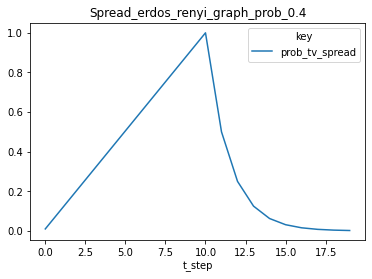

In [12]:
analysis.plot_all('soil_output/Spread_erdos*', analysis.get_value, 'prob_tv_spread');

### Manually plotting with pandas

Although the simplest way to visualize the results of a simulation is to use the built-in methods in the analysis module, sometimes the setup is more complicated and we need to explore the data a little further.

For that, we can use native pandas over the results.

Soil provides some convenience methods to simplify common operations:

* `analysis.split_df` to separate a history dataframe into environment and agent parameters.
* `analysis.get_count` to get a dataframe with the value counts for different attributes during the simulation.
* `analysis.get_value` to get the evolution of the value of an attribute during the simulation.

And, as we saw earlier, `analysis.process` can turn a dataframe in canonical form into a dataframe with a column per attribute.


In [14]:
df = analysis.read_sql('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0-0_trial_1605820891-4782693.sqlite')
df

key                                                    SEED  \
agent_id                                                env   
t_step                                                        
0         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
1         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
2         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
3         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
4         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
5         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
6         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
7         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
8         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
9         Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
10        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
11        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
12        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
13        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
14        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
15        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
16        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
17        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
18        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   
19        Spread_barabasi_albert_graph_prob_0.0_trial_Sp...   

key                event_time has_tv                                      \
agent_id NewsEnvironmentAgent      0     1    10   100   101   102   103   
t_step                                                                     
0                          10   True  True  True  True  True  True  True   
1                          10   True  True  True  True  True  True  True   
2                          10   True  True  True  True  True  True  True   
3                          10   True  True  True  True  True  True  True   
4                          10   True  True  True  True  True  True  True   
5                          10   True  True  True  True  True  True  True   
6                          10   True  True  True  True  True  True  True   
7                          10   True  True  True  True  True  True  True   
8                          10   True  True  True  True  True  True  True   
9                          10   True  True  True  True  True  True  True   
10                         10   True  True  True  True  True  True  True   
11                         10   True  True  True  True  True  True  True   
12                         10   True  True  True  True  True  True  True   
13                         10   True  True  True  True  True  True  True   
14                         10   True  True  True  True  True  True  True   
15                         10   True  True  True  True  True  True  True   
16                         10   True  True  True  True  True  True  True   
17                         10   True  True  True  True  True  True  True   
18                         10   True  True  True  True  True  True  True   
19                         10   True  True  True  True  True  True  True   

key             ...        id                                                  \
agent_id   104  ...        92       93        94        95       96        97   
t_step          ...                                                             
0         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
1         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
2         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
3         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
4         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
5         True  ...   neutral  neutral   neutral   neutral  neutral   neutral   
6         True  ...   neutral  neutral   neutral   neutral  neutral   ne

Let's look at the evolution of agent parameters in the simulation

<AxesSubplot:xlabel='t_step'>

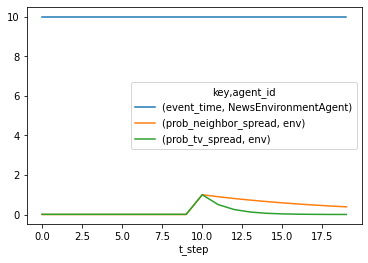

In [15]:
df.plot()

As we can see, `event_time` is cluttering our results, 

<AxesSubplot:xlabel='t_step'>

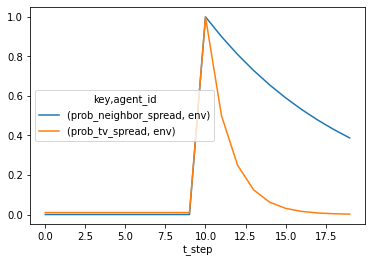

In [16]:
del df['event_time']
df.plot()

The `soil.analysis` module also provides convenient functions to count the number of agents in a given state:

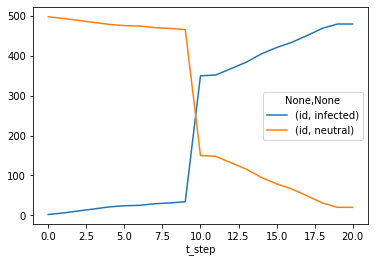

In [19]:
analysis.get_count(agents, 'id').plot();

## Dealing with bigger data

In [20]:
from soil import analysis

In [21]:
!du -xsh ../rabbits/soil_output/rabbits_example/

215M	../rabbits/soil_output/rabbits_example/


If we tried to load the entire history, we would probably run out of memory. Hence, it is recommended that you also specify the attributes you are interested in.

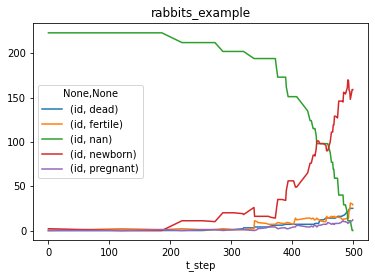

In [31]:
p = analysis.plot_all('../rabbits/soil_output/rabbits_example/', analysis.get_count, 'id')

In [60]:
df = analysis.read_sql('../rabbits/soil_output/rabbits_example/rabbits_example_trial_1605825338-8931234.sqlite', keys=['id', 'rabbits_alive'])

<AxesSubplot:xlabel='t_step'>

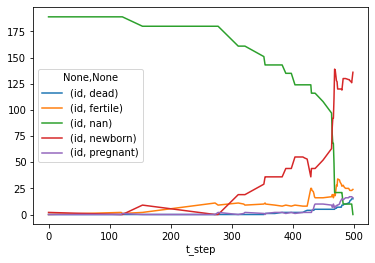

In [61]:
states = analysis.get_count(df, 'id')
states.plot()

<AxesSubplot:xlabel='t_step'>

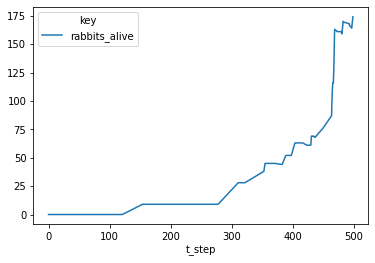

In [62]:
alive = analysis.get_value(df, 'rabbits_alive', aggfunc='sum').apply(pd.to_numeric)
alive.plot()

/home/j/.local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


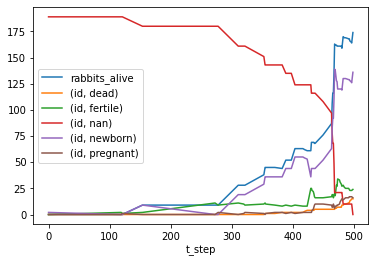

In [63]:
h = alive.join(states);
h.plot();